https://medium.com/analytics-vidhya/classifying-tech-data-job-postings-on-indeed-com-1fd8ca6e7cdd

this article examines and analyzes a small subset of current job postings sourced from Indeed.com. We then dive into the details and steps of how to build a machine learning model for classifying job postings, based on the job description text, using natural language processing (NLP) techniques. Finally, the job posting data is visualized using dimensionality reduction algorithms, to visualize the data in low-dimensional (2D) space.

https://github.com/vincent99-git/Data_Job_Analysis/blob/master/job_analyzer.ipynb

Indeed Web Scrapping - https://medium.com/@msalmon00/web-scraping-job-postings-from-indeed-96bd588dcb4b

# Job Classifier Notebook Using NLP and ML

This notebook uses natural language processing and machine learning to classify IAM jobs based on the job description text.

## 1. Install and load packages

In [1]:
pip install numpy pandas sklearn wordcloud textblob

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn import linear_model, naive_bayes, svm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


## 2. Load data into a dataframe

In [2]:
df = pd.read_csv("../project_data/data-jobs-20221123.csv", encoding = "utf-8")
df.head()

,job_title,role,description,knowledge,skills,tasks,education_level,experience,certifications
0,Identity and Access Management Administrator,administrator,Job Summary\nThe Identity and Access Managemen...,NaN,NaN,NaN,NaN,NaN,NaN
1,Systems Administrator (Hybrid Remote),administrator,The Christar Mobilization Center U.S. (CMCUS) ...,NaN,NaN,NaN,NaN,NaN,NaN
2,IT Administrator/Helpdesk,administrator,IT Administrator/Helpdesk\nIf you are a IT Adm...,NaN,NaN,NaN,NaN,NaN,NaN
3,IT Administrator/Helpdesk L2/L3,administrator,IT Administrator/Helpdesk L2/L3\nIf you are a ...,NaN,NaN,NaN,NaN,NaN,NaN
4,Identity Access Management AD Systems Administ...,administrator,Deloitte Global is the engine of the Deloitte ...,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Tokenize and clean job description

In [7]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')

other_stop_words = ['introduction', 'searching', 'opportunity', 'play','working','without','preferred', 'people', 'well','veteran', 'status','dramatic', 'growth', 'highly']

stop_words.extend(other_stop_words)

#lowercase
df["desc_1"] = df.description.str.lower()
#remove \n
df["desc_2"] = df.desc_1.str.replace("\n", " ")
#remove punctuation and tokenize
df["Tokens"] = df.apply(lambda row: tokenizer.tokenize(row['desc_2']), axis=1)
#remove stopwords
df['Tokens_1'] = df['Tokens'].apply(lambda x: [item for item in x if item not in stop_words])
#merge tokens back into string text
df['desc_3']=[" ".join(txt) for txt in df["Tokens_1"].values]
#create bigrams
df["Tokens_2"] = df["Tokens_1"].apply(lambda row: list(ngrams(row, 2)))
df.head()

,job_title,role,description,desc_1,desc_2,Tokens,Tokens_1,desc_3,Tokens_2
0,Identity and Access Management Administrator,administrator,Job Summary\nThe Identity and Access Managemen...,job summary\nthe identity and access managemen...,job summary the identity and access management...,"[job, summary, the, identity, and, access, man...","[job, summary, identity, access, management, a...",job summary identity access management adminis...,"[(job, summary), (summary, identity), (identit..."
1,Systems Administrator (Hybrid Remote),administrator,Systems Administrator (Hybrid Remote)\n\nChris...,systems administrator (hybrid remote)\n\nchris...,systems administrator (hybrid remote) christa...,"[systems, administrator, hybrid, remote, chris...","[systems, administrator, hybrid, remote, chris...",systems administrator hybrid remote christar i...,"[(systems, administrator), (administrator, hyb..."
2,IT Administrator/Helpdesk,administrator,IT Administrator/Helpdesk\nIf you are a IT Adm...,it administrator/helpdesk\nif you are a it adm...,it administrator/helpdesk if you are a it admi...,"[it, administrator, helpdesk, if, you, are, a,...","[administrator, helpdesk, administrator, least...",administrator helpdesk administrator least two...,"[(administrator, helpdesk), (helpdesk, adminis..."
3,IT Administrator/Helpdesk L2/L3,administrator,IT Administrator/Helpdesk L2/L3\nIf you are a ...,it administrator/helpdesk l2/l3\nif you are a ...,it administrator/helpdesk l2/l3 if you are a i...,"[it, administrator, helpdesk, l2, l3, if, you,...","[administrator, helpdesk, l2, l3, administrato...",administrator helpdesk l2 l3 administrator lea...,"[(administrator, helpdesk), (helpdesk, l2), (l..."
4,Identity Access Management AD Systems Administ...,administrator,Deloitte Global is the engine of the Deloitte ...,deloitte global is the engine of the deloitte ...,deloitte global is the engine of the deloitte ...,"[deloitte, global, is, the, engine, of, the, d...","[deloitte, global, engine, deloitte, network, ...",deloitte global engine deloitte network profes...,"[(deloitte, global), (global, engine), (engine..."


## 4. Generate Labels (label)

In [8]:
encoder = LabelEncoder()
label = encoder.fit_transform(df.role)
print(label)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7
 7 7 7 7 7 7 7 7 7]


## 5. Transform job description text into term frequency–inverse document frequency (TDIDF) format and make ML model with accuracy score

Determine the classifer accuracy based on the max words.

In [9]:
v = TfidfVectorizer(max_features=200, min_df=.2, max_df=.7)

x = df["desc_3"]

v.fit(x)

x_tfidf = v.transform(x)

#print(x_tfidf)

#use to see high frequency words
#print(v2.get(99))

#print(v.vocabulary_)

# Classifier - Algorithm - SVM
s = svm.LinearSVC(C=1.0)

# fit the training dataset on the classifier
s.fit(x_tfidf, label)# predict the labels on validation dataset

# make predictions using the trained model
s_pred = s.predict(x_tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(s_pred, label)*100)


SVM Accuracy Score ->  92.27373068432672


## 7. Identify model gaps using confusion matrix

Confusion matrix, without normalization


array(['administrator', 'analyst', 'architect', 'developer', 'engineer',
       'leadership', 'manager', 'specialist'], dtype=object)

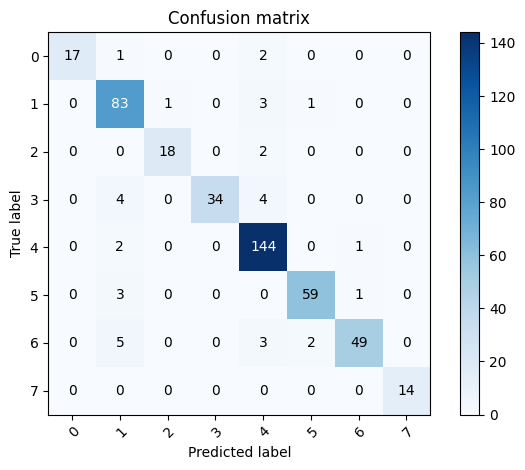

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.unique(label)

plot_confusion_matrix(label, s_pred, classes=class_names, title='Confusion matrix')

np.unique(df.role)

## 8. Plot roles

/Users/kenmye/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kenmye/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


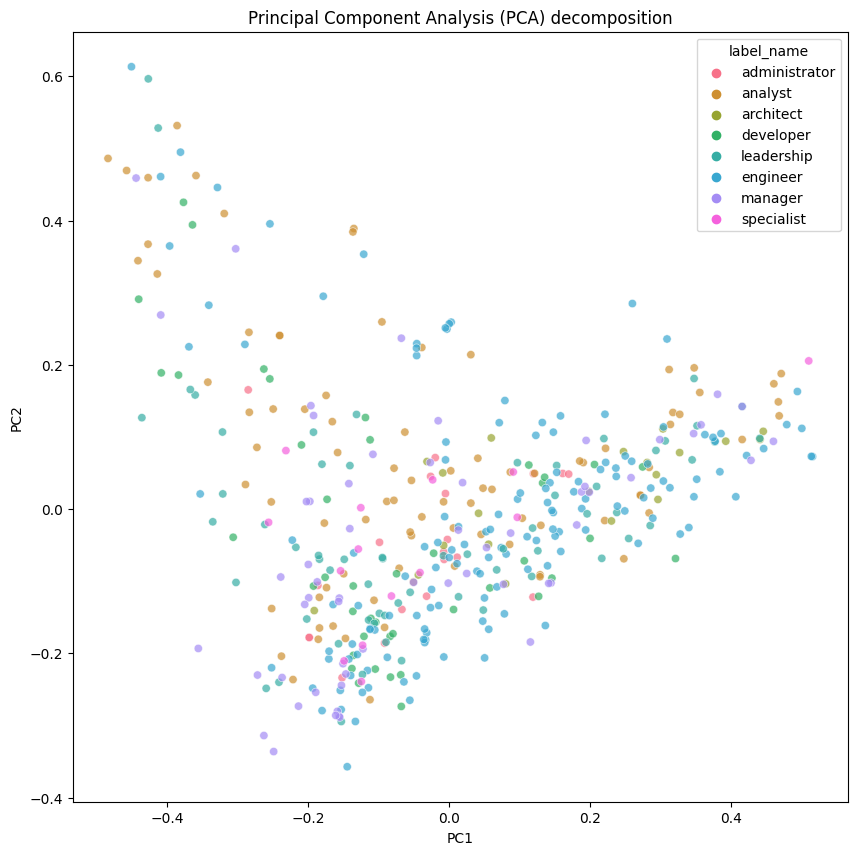

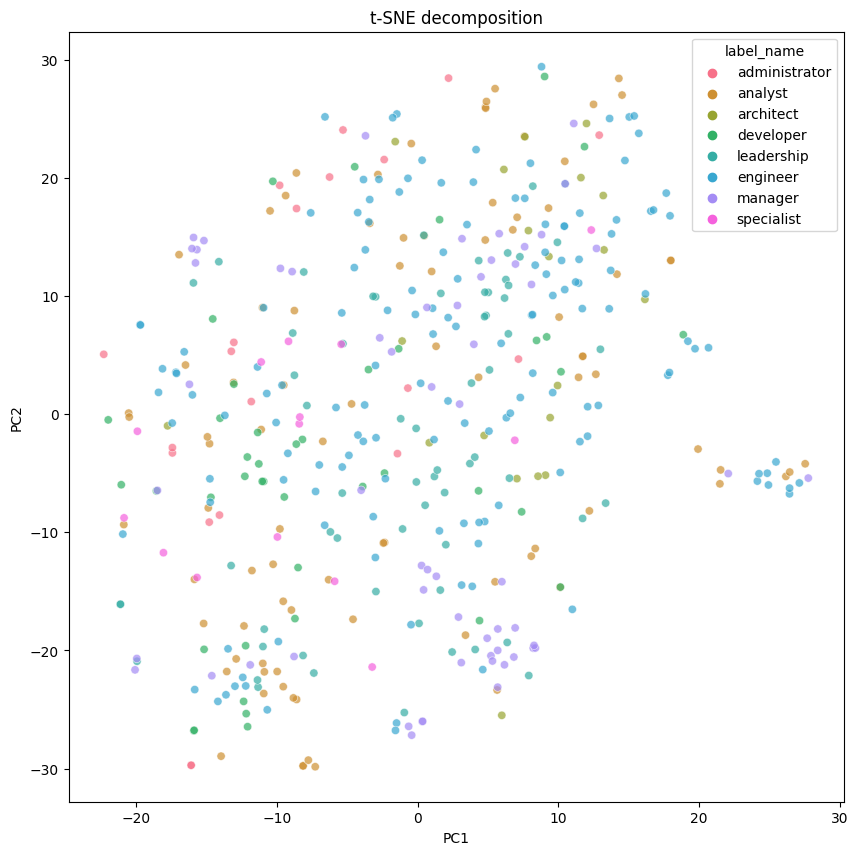

In [13]:
def plot_dim_red(model, features, labels, n_components=2):
    
    # Creation of the model
    if (model == 'PCA'):
        mod = PCA(n_components=n_components)
        title = "Principal Component Analysis (PCA) decomposition"  # for the plot
        
    elif (model == 'TSNE'):
        mod = TSNE(n_components=2)
        title = "t-SNE decomposition" 

    else:
        return "Error"
    
    # Fit and transform the features
    principal_components = mod.fit_transform(features)
    
    # Put them into a dataframe
    df_features = pd.DataFrame(data=principal_components,
                     columns=['PC1', 'PC2'])
    
    # Now we have to paste each row's label and its meaning
    # Convert labels array to df
    df_labels = pd.DataFrame(data=labels,
                             columns=['label'])
    
    df_full = pd.concat([df_features, df_labels], axis=1)
    df_full['label'] = df_full['label'].astype(str)

    # Get labels name
    category_names = {
        "0": 'administrator',
        "1": 'analyst',
        "2": 'architect',
        "3": 'developer',
        "4": 'engineer',
        "5": 'leadership',
        "6": 'manager',
        "7": 'specialist'
    }

    # And map labels
    df_full['label_name'] = df_full['label']
    df_full = df_full.replace({'label_name':category_names})

    # Plot
    plt.figure(figsize=(10,10))
    sns.set_palette("hls", 5)
    sns.scatterplot(x='PC1',
                    y='PC2',
                    hue="label_name", 
                    data=df_full,
                    #palette=["red", "orange", "darkgreen", "blue", "purple"],
                    alpha=.7).set_title(title);

plot_dim_red("PCA", features=x_tfidf.toarray(), labels=label, n_components=2)

plot_dim_red("TSNE", features=x_tfidf.toarray(), labels=label, n_components=2)

df["SVM_Prediction"] = s_pred

#from pathlib import Path  
#filepath = Path('out.csv')  
#df.to_csv(filepath) 